# Импортируем библиотеки

In [102]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns


# ------- Метрики расстояния ------

In [103]:
def euclidean(u, v):
    """Евклидово расстояние (L2)."""
    return np.linalg.norm(u - v)

def manhattan(u, v):
    """Манхэттенское расстояние (L1)."""
    return np.sum(np.abs(u - v))

def minkowski(u, v, p=3):
    """Минковского расстояние с параметром p. По умолчанию p=3.
    p=2 эквивалентно евклидову, p=1 — манхэттену.
    """
    return np.sum(np.abs(u - v) ** p) ** (1.0 / p)

def cosine_distance(u, v):
    """Косинусное расстояние: 1 - косинусная схожесть.
    Важно: косинусная мера игнорирует длину векторов, только направление.
    """
    # защита от деления на ноль
    u_norm = np.linalg.norm(u)
    v_norm = np.linalg.norm(v)
    if u_norm == 0 or v_norm == 0:
        return 1.0
    cos_sim = np.dot(u, v) / (u_norm * v_norm)
    # численные погрешности: ограничим значение в [-1, 1]
    cos_sim = np.clip(cos_sim, -1.0, 1.0)
    return 1.0 - cos_sim

# Словарь доступных метрик для удобства
_METRIC_FUNCS = {
    'euclidean': lambda u, v, **kw: euclidean(u, v),
    'manhattan': lambda u, v, **kw: manhattan(u, v),
    'minkowski': lambda u, v, p, **kw: minkowski(u, v, p=p),
    'cosine': lambda u, v, **kw: cosine_distance(u, v),
}

Datasets init

In [104]:
data_v2 = pd.read_csv('Datasets/healthcare-dataset-stroke-data.csv')
data_v2.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [105]:
data_v2.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [106]:
data_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [107]:
# 2. Заполняем пропуски
numeric_cols = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Числовые → среднее
for col in numeric_cols:
   data_v2[col] = data_v2[col].fillna(data_v2[col].mean())

# Категориальные → отдельная категория 'Unknown'
for col in categorical_cols:
    data_v2[col] = data_v2[col].fillna('Unknown')

# 4. Масштабируем числовые признаки
scaler = StandardScaler()
data_v2[numeric_cols] = scaler.fit_transform(data_v2[numeric_cols])

# 5. Кодируем категориальные признаки через OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' для избежания дамми-ловушки
cat_encoded = ohe.fit_transform(data_v2[categorical_cols])

# Получаем имена новых признаков
cat_feature_names = ohe.get_feature_names_out(categorical_cols)

# Превращаем в DataFrame и объединяем с числовыми
df_cat = pd.DataFrame(cat_encoded, columns=cat_feature_names, index=data_v2.index)
data_v2_X = pd.concat([data_v2[numeric_cols], df_cat], axis=1)

# 6. Целевая переменная
data_v2_y = data_v2['stroke']


print("Признаки после преобразования (первые 5 строк):")
print(data_v2_X.head())
print("\nЦелевая переменная:")
print(data_v2_y.head())
print("\nФорма X:", data_v2_X.shape)
# 7. Разделяем на train и test
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    data_v2_X, data_v2_y, test_size=0.2, random_state=42, stratify=y
)


Признаки после преобразования (первые 5 строк):
        age  avg_glucose_level           bmi  hypertension  heart_disease  \
0  1.051434           2.706375  1.001234e+00     -0.328602       4.185032   
1  0.786070           2.121559  4.615554e-16     -0.328602      -0.238947   
2  1.626390          -0.005028  4.685773e-01     -0.328602       4.185032   
3  0.255342           1.437358  7.154182e-01     -0.328602      -0.238947   
4  1.582163           1.501184 -6.357112e-01      3.043196      -0.238947   

   gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
0          1.0           0.0               1.0                     0.0   
1          0.0           0.0               1.0                     0.0   
2          1.0           0.0               1.0                     0.0   
3          0.0           0.0               1.0                     0.0   
4          0.0           0.0               1.0                     0.0   

   work_type_Private  work_type_Self-employe

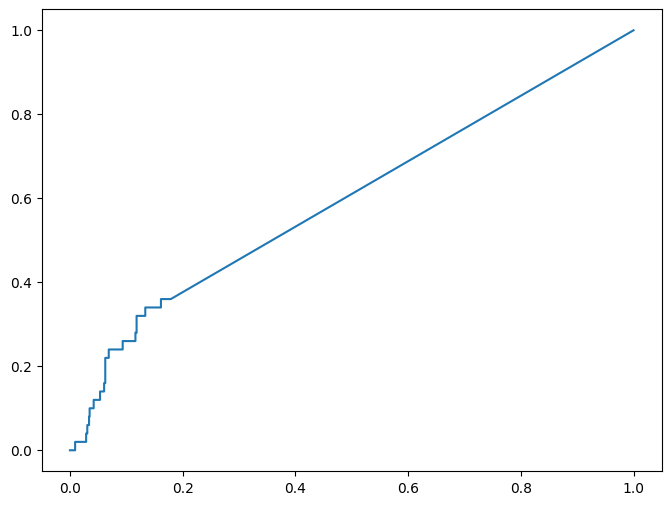

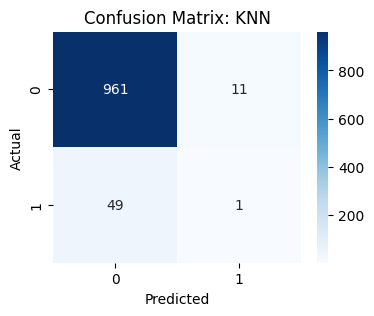

Classification Report for KNN:

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.08      0.02      0.03        50

    accuracy                           0.94      1022
   macro avg       0.52      0.50      0.50      1022
weighted avg       0.91      0.94      0.92      1022

------------------------------------------------------------


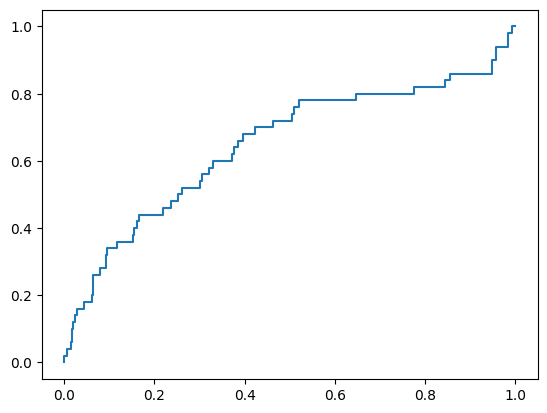

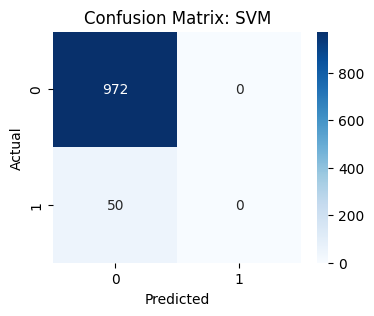

Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

------------------------------------------------------------


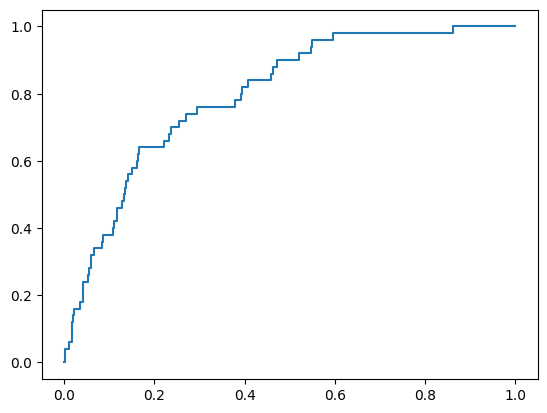

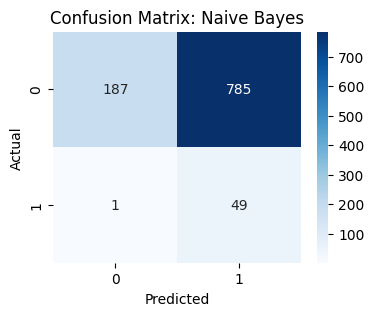

Classification Report for Naive Bayes:

              precision    recall  f1-score   support

           0       0.99      0.19      0.32       972
           1       0.06      0.98      0.11        50

    accuracy                           0.23      1022
   macro avg       0.53      0.59      0.22      1022
weighted avg       0.95      0.23      0.31      1022

------------------------------------------------------------


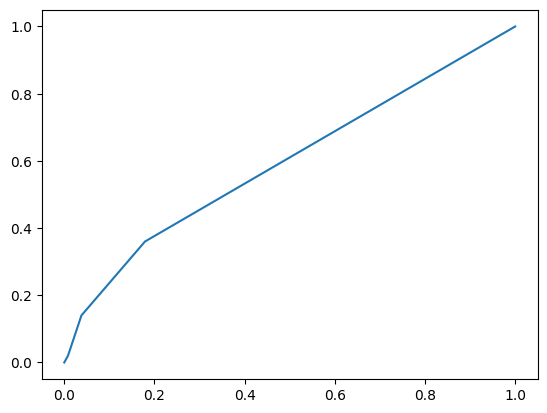

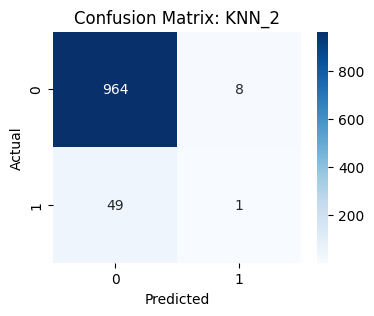

Classification Report for KNN_2:

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.11      0.02      0.03        50

    accuracy                           0.94      1022
   macro avg       0.53      0.51      0.50      1022
weighted avg       0.91      0.94      0.93      1022

------------------------------------------------------------


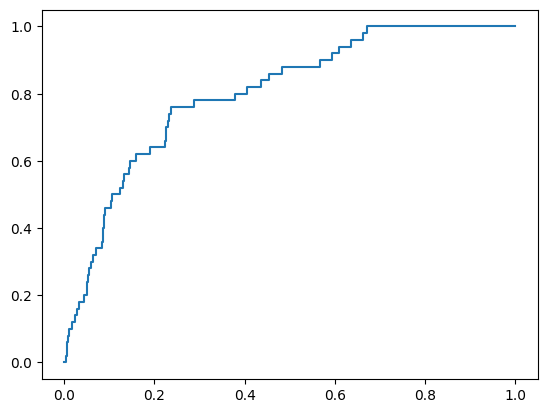

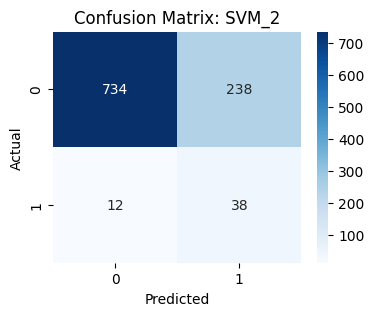

Classification Report for SVM_2:

              precision    recall  f1-score   support

           0       0.98      0.76      0.85       972
           1       0.14      0.76      0.23        50

    accuracy                           0.76      1022
   macro avg       0.56      0.76      0.54      1022
weighted avg       0.94      0.76      0.82      1022

------------------------------------------------------------
Метрики классификации:
         Model  Accuracy  Precision  Recall  F1-score     Error
0          KNN  0.941292   0.083333    0.02  0.032258  0.058708
1          SVM  0.951076   0.000000    0.00  0.000000  0.048924
2  Naive Bayes  0.230920   0.058753    0.98  0.110860  0.769080
3        KNN_2  0.944227   0.111111    0.02  0.033898  0.055773
4        SVM_2  0.755382   0.137681    0.76  0.233129  0.244618


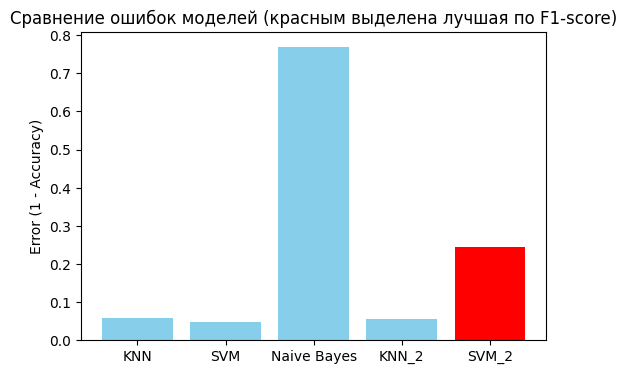

Лучшая модель по F1-score класса 1: SVM_2 (F1 = 0.2331)


In [108]:

# ----------------------------
# 8. Обучение моделей и предсказания
# ----------------------------
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5,weights='distance'),
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True),
    'Naive Bayes': GaussianNB(),
    'KNN_2': KNeighborsClassifier(n_neighbors=5),
    'SVM_2': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True,class_weight='balanced'),
}

results = []
best_f1 = 0
best_model_name = ''

plt.figure(figsize=(8,6))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]  # для ROC

    # Метрики
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    error = 1 - acc

    results.append([name, acc, prec, rec, f1, error])

    if f1 > best_f1:
        best_f1 = f1
        best_model_name = name

    # ROC-кривая
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("-"*60)

# ----------------------------
# 9. Таблица с метриками
# ----------------------------
metrics_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'Error'])
print("Метрики классификации:")
print(metrics_df)

# ----------------------------
# # 10. ROC-кривая всех моделей
# # ----------------------------
# plt.plot([0,1], [0,1], 'k--')  # диагональ
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC-кривые моделей')
# # Отметим лучшую модель звездочкой
# plt.legend([f"{label} {'<-- Best F1' if label.startswith(best_model_name) else ''}" for label in [l.get_label() for l in plt.gca().get_lines()]],
#            loc='lower right')
# plt.show()

# ----------------------------
# 11. График ошибок с выделением лучшей модели
# ----------------------------
plt.figure(figsize=(6,4))
colors = ['skyblue' if model != best_model_name else 'red' for model in metrics_df['Model']]
plt.bar(metrics_df['Model'], metrics_df['Error'], color=colors)
plt.ylabel('Error (1 - Accuracy)')
plt.title('Сравнение ошибок моделей (красным выделена лучшая по F1-score)')
plt.show()

print(f"Лучшая модель по F1-score класса 1: {best_model_name} (F1 = {best_f1:.4f})")

В датасете stroke:
- Большинство пациентов — stroke = 0 (нет инсульта)
- Меньшинство — stroke = 1 (инсульт)

Если использовать accuracy (доля правильных предсказаний), то модель может просто всегда предсказывать 0.

1) Тогда accuracy будет высокой (~95%), но редкий класс будет полностью проигнорирован.

2) В реальной медицинской задаче важнее правильно выявлять инсульт, а не просто угадать большинство.

Выбор модели по F1-score

1) Для дисбалансных задач (редкие события) F1-score для редкого класса лучше отражает качество модели, чем простая accuracy.

2) Accuracy может быть обманчива, F1-score учитывает баланс Precision и Recall, что важно в медицине или других задачах с редкими событиями.

In [109]:
data_v3 = pd.read_csv('Datasets/healthcare_dataset.csv')
data_v3.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [110]:
data_v3.columns

Index(['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results'],
      dtype='object')

In [111]:
data_v3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

In [112]:
df = data_v3
# 2. Заполняем пропуски
numeric_cols = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [113]:
def correct_table(df, numeric_cols, categorical_cols):
    # Числовые → среднее
    for col in numeric_cols:
       df [col] = df [col].fillna(df [col].mean())

    # Категориальные → отдельная категория 'Unknown'
    for col in categorical_cols:
        df[col] = df[col].fillna('Unknown')

    # 4. Масштабируем числовые признаки
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    # 5. Кодируем категориальные признаки через OneHotEncoder
    ohe = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' для избежания дамми-ловушки
    cat_encoded = ohe.fit_transform(df[categorical_cols])

    # Получаем имена новых признаков
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)

    # Превращаем в DataFrame и объединяем с числовыми
    df_cat = pd.DataFrame(cat_encoded, columns=cat_feature_names, index=data_v2.index)
    X = pd.concat([df[numeric_cols], df_cat], axis=1)

    # 6. Целевая переменная
    y = data_v2['stroke']

    print("Признаки после преобразования (первые 5 строк):")
    print(X.head())
    print("\nЦелевая переменная:")
    print(y.head())
    print("\nФорма X:", X.shape)
    return X,y

In [114]:
data_v4 = pd.read_csv('Datasets/loan_data.csv')
data_v4.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [115]:
data_v4.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')

In [116]:
data_v5 = pd.read_csv('Datasets/Student_performance_data _.csv')
data_v5.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [117]:
data_v5.columns

Index(['StudentID', 'Age', 'Gender', 'Ethnicity', 'ParentalEducation',
       'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport',
       'Extracurricular', 'Sports', 'Music', 'Volunteering', 'GPA',
       'GradeClass'],
      dtype='object')

In [118]:
data_v6_te = pd.read_csv('Datasets/data/test.csv', delimiter=';')
data_v6_tr = pd.read_csv('Datasets/data/train.csv',delimiter=';')
data_v6_te.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [119]:
data_v6_te.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [120]:
data_v6_tr.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [121]:
data_v6_tr.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [122]:
data_zoo = pd.read_csv('Datasets/Zoo/zoo.csv')
data_zoo_class = pd.read_csv('Datasets/Zoo/class.csv')
data_zoo.head()


,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [123]:
data_zoo.columns

Index(['animal_name', 'hair', 'feathers', 'eggs', 'milk', 'airborne',
       'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous',
       'fins', 'legs', 'tail', 'domestic', 'catsize', 'class_type'],
      dtype='object')